# Deep Unfolding

In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.optim as optim
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

MNIST DATASET PREPERATION

In [47]:
class Noisy_MNIST(Dataset):
    # initialization of the dataset
    def __init__(self, split, data_loc, noise=0.5):
        # save the input parameters
        self.split    = split 
        self.data_loc = data_loc
        self.noise    = noise
        
        if self.split == 'train':
            Train = True
        else:
            Train = False
            
        # get the original MNIST dataset   
        Clean_MNIST = datasets.MNIST(self.data_loc, train=Train, download=True)
        
        # reshuffle the test set to have digits 0-9 at the start
        if self.split == 'train':
            data = Clean_MNIST.data.unsqueeze(1)
        else:
            data = Clean_MNIST.data.unsqueeze(1)
            idx = torch.load('test_idx.tar')
            data[:,:] = data[idx,:]
            
        
        # reshape and normalize
        resizer = transforms.Resize(32)
        resized_data = resizer(data)*1.0
        normalized_data = 2 *(resized_data/255) - 1
        # print("min =", normalized_data.min())
        # print("max =", normalized_data.max())
        
        # create the data
        self.Clean_Images = normalized_data
        self.Noisy_Images = normalized_data + torch.randn(normalized_data.size())*self.noise
        self.Labels       = Clean_MNIST.targets
    
    # return the number of examples in this dataset
    def __len__(self):
        return self.Labels.size(0)
    
    # create a a method that retrieves a single item form the dataset
    def __getitem__(self, idx):
        clean_image = self.Clean_Images[idx,:,:,:]
        noisy_image = self.Noisy_Images[idx,:,:,:]
        label =  self.Labels[idx]
        
        return clean_image,noisy_image,label

In [48]:
# %% dataloader for the Noisy MNIST dataset
def create_dataloaders(data_loc, batch_size):
    Noisy_MNIST_train = Noisy_MNIST("train", data_loc)
    Noisy_MNIST_test  = Noisy_MNIST("test" , data_loc)
    
    Noisy_MNIST_train_loader =  DataLoader(Noisy_MNIST_train, batch_size=batch_size, shuffle=True,  drop_last=False)
    Noisy_MNIST_test_loader  =  DataLoader(Noisy_MNIST_test , batch_size=batch_size, shuffle=False, drop_last=False)
    
    return Noisy_MNIST_train_loader, Noisy_MNIST_test_loader

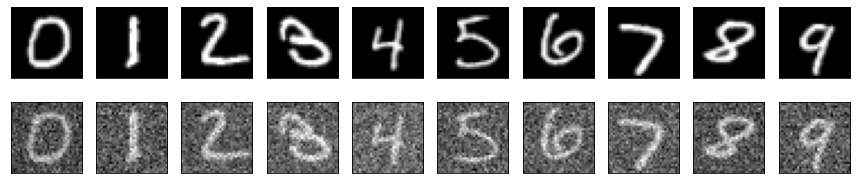

In [49]:
# define parameters
data_loc = 'MNIST Datasets' #change the datalocation to something that works for you
batch_size = 64

# get dataloader
train_loader, test_loader = create_dataloaders(data_loc, batch_size)

# get some examples
examples = enumerate(test_loader)
_, (x_clean_example, x_noisy_example, labels_example) = next(examples)
# use these example images througout the assignment as the first 10 correspond to the digits 0-9

# show the examples in a plot
plt.figure(figsize=(12,3))
for i in range(10):
    plt.subplot(2,10,i+1)
    plt.imshow(x_clean_example[i,0,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(2,10,i+11)
    plt.imshow(x_noisy_example[i,0,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.savefig("data_examples.png", dpi=300, bbox_inches='tight')
plt.show()

In [52]:
# Creating the test set and train set
x_clean_train = train_loader.dataset.Clean_Images
x_noisy_train = train_loader.dataset.Noisy_Images
labels_train  = train_loader.dataset.Labels

x_clean_test  = test_loader.dataset.Clean_Images
x_noisy_test  = test_loader.dataset.Noisy_Images
labels_test   = test_loader.dataset.Labels

# use these 10 examples as representations for all digits
x_clean_example = x_clean_test[0:10,:,:,:]
x_noisy_example = x_noisy_test[0:10,:,:,:]
labels_example = labels_test[0:10]


## Exercise 1 - ISTA
EXERCISE 1A

In [6]:
def soft_threshold(x, Lambda):
    return torch.sign(x) * torch.relu(torch.abs(x)-Lambda)

def ISTA(mu, Lambda, K, y):
    A = torch.eye(y.shape[1])
    x = torch.zeros((y.shape[0], y.shape[1]))
    for _ in tqdm(range(K)):
        y_new = y@(mu*A)      
        x_new = x@(torch.eye(y.shape[1])-mu*A@A.T)
        x = soft_threshold(y_new + x_new, Lambda)
    return x 

In [86]:
noisy_measurements = x_noisy_example
noisy_measurements = noisy_measurements.reshape(len(noisy_measurements), -1)  # flatten the input

# Parameter values for ISTA
mu = 1
Lambda = 1.3
K = 10

reconstructed_x = ISTA(mu, Lambda, K, noisy_measurements + 2)       # offset = 2 for better filtering

100%|██████████| 10/10 [00:00<00:00, 88.36it/s]


EXERCISE 1B



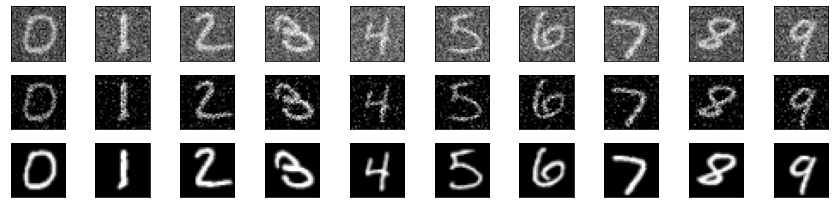

In [87]:
# show the examples in a plot
reconstructed_x = torch.reshape(reconstructed_x, (reconstructed_x.shape[0], 1, 32, 32))

plt.figure(figsize=(12,3))
for i in range(10):
    plt.subplot(3, 10, i+1)
    plt.imshow(x_noisy_example[i,0,:,:], cmap='gray')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(3, 10, i+11)
    plt.imshow(reconstructed_x[i,0,:,:], cmap='gray')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(3, 10, i+21)
    plt.imshow(x_clean_example[i,0,:,:], cmap='gray')
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.savefig("data_examples.png", dpi=100, bbox_inches='tight')
plt.show()

In [88]:
# Showing range of output
print("Minimum value =", reconstructed_x.min().item())
print("Maximum value =", reconstructed_x.max().item())

Minimum value = 0.0
Maximum value = 3.139117956161499


EXERCISE 1C

In [89]:
# Converting the tensor to numpy array of size N x 1024
x_noisy_test_flatten = x_noisy_test
x_noisy_test_flatten = x_noisy_test_flatten.reshape(len(x_noisy_test_flatten), -1)
reconstructed_x_test = ISTA(mu, Lambda, K, x_noisy_test_flatten)

# Calculating MSE Loss
mse_loss = nn.MSELoss()
reconstructed_x_test = reconstructed_x_test.reshape(len(reconstructed_x_test), 1, 32, 32)
rec_x_test_tensor = reconstructed_x_test
loss = mse_loss(rec_x_test_tensor, x_clean_test)
print('MSE loss for ISTA is', loss.item())


100%|██████████| 10/10 [00:01<00:00,  6.08it/s]

MSE loss for ISTA is 0.7743699550628662


## Exercise 2 - LISTA


In [36]:
USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cuda


EXERCISE 2A

In [79]:
def soft_threshold_LISTA(x, lamda):
    x = x + 0.5*(torch.sqrt(torch.pow(x-lamda, 2) + 1) - torch.sqrt(torch.pow(x+lamda, 2) + 1))
    return x

class ConvUnit(nn.Module):
    def __init__(self, conv1, conv2):
        super().__init__()
        self.conv1 = conv1
        self.conv2 = conv2
        self.lamda = Variable(torch.zeros(1), requires_grad=True)

    def forward(self, y, x):
        y_new = self.conv1(y)
        x_new = self.conv2(x)
        x_new = soft_threshold_LISTA(y_new + x_new, self.lamda.to(device=device))
        return x_new


class LISTA(nn.Module):
    def __init__(self, K):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 1, (5,5), padding=2, stride=1)
        self.conv2 = nn.Conv2d(1, 1, (5,5), padding=2, stride=1)
        self.list = nn.ModuleList([ConvUnit(self.conv1, self.conv2) for _ in range(K)])
    
    def forward(self, y):
        x = torch.zeros((y.shape[0], 1, 32 ,32)).to(device=device)
        for m in self.list:
            x = m(y, x)
        return x


In [102]:
# define training function
def train_LISTA(model, optimizer, epochs=1):
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in tqdm(range(epochs)):
        for _, (x, y, _) in enumerate(train_loader):
            model.train()  # put model to training mode
            y = y.to(device=device, dtype=torch.float32)
            x = x.to(device=device, dtype=torch.float32)
            scores = model(y)
            # loss = F.mse_loss(scores.reshape(len(scores), -1), x.reshape(len(x), -1))
            loss = F.mse_loss(scores, x)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

# train model
model = LISTA(3)

learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
epoch = 10

train_LISTA(model, optimizer, epoch)

# save model
PATH = os.path.join(os.getcwd(), "model_ex2.pt")
torch.save(model, PATH)

100%|██████████| 10/10 [02:49<00:00, 16.97s/it]


EXERCISE 2B

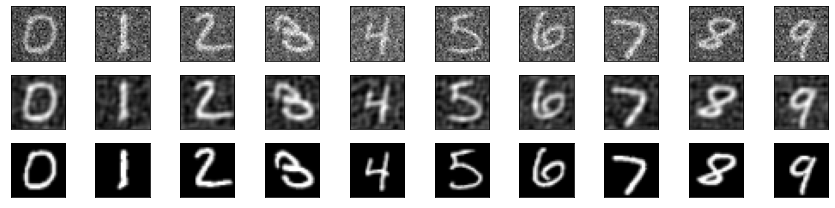

In [103]:
# load the model
PATH = os.path.join(os.getcwd(), "model_ex2.pt")
model_trained = torch.load(PATH)

# load the example data
noisy_measurements = x_noisy_example
reconstructed_x = torch.Tensor.cpu(model_trained(noisy_measurements.to(device=device))).detach().numpy()

# show the examples in a plot
plt.figure(figsize=(12,3))
for i in range(10):
    plt.subplot(3, 10, i+1)
    plt.imshow(x_noisy_example[i,0,:,:], cmap='gray')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(3, 10, i+11)
    plt.imshow(reconstructed_x[i,0,:,:], cmap='gray')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(3, 10, i+21)
    plt.imshow(x_clean_example[i,0,:,:], cmap='gray')
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.savefig("data_examples.png", dpi=100, bbox_inches='tight')
plt.show()

EXERCISE 2C

In [104]:
# Calculating MSE Loss
mse_loss = nn.MSELoss()

reconstructed_x = torch.Tensor.cpu(model_trained(x_noisy_test.to(device=device)))

loss = mse_loss(reconstructed_x, x_clean_test)
print('MSE loss for LISTA is', loss.item())

MSE loss for LISTA is 0.04164845496416092


EXERCISE 2D </br>
<font color=red> To be done!! </font>

## Exercise 3 - MRI helper functions